In [58]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.data import Dataset
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
dataset_path = 'C:\\Users\\User\\Desktop\\Data_Science\\Projects\\HW_27_Image_Generators\\data_set_cat_dogs'

In [9]:
_aug_generator = ImageDataGenerator(
                               rotation_range = 40,
                                width_shift_range = 0.2,
                                height_shift_range = 0.2,
                                zoom_range = 0.2,
                                shear_range = 0.2,
                                horizontal_flip = True,
                                fill_mode = 'nearest',
                                validation_split = 0.2
                                    )

In [11]:
_train_aug_generator = _aug_generator.flow_from_directory(
    dataset_path,
    class_mode = 'categorical',
    seed = 123,
    subset = 'training'
)

_test_aug_generator = _aug_generator.flow_from_directory(
    dataset_path,
    class_mode = 'categorical',
    seed = 123,
    subset = 'validation'
)

Found 814 images belonging to 2 classes.
Found 202 images belonging to 2 classes.


In [13]:
train_aug_img_list = []
train_aug_lbl_list = []
for i in range(len(_train_aug_generator)):
        x_batch, y_batch = _train_aug_generator[i]
        train_aug_img_list.extend(x_batch)
        train_aug_lbl_list.extend(y_batch)

test_aug_img_list = []
test_aug_lbl_list = []
for i in range(len(_test_aug_generator)):
        x_batch, y_batch = _test_aug_generator[i]
        test_aug_img_list.extend(x_batch)
        test_aug_lbl_list.extend(y_batch)

In [15]:
train_aug_img = np.array(train_aug_img_list)
train_aug_lbl = np.array(train_aug_lbl_list)
test_aug_img = np.array(test_aug_img_list)
test_aug_lbl = np.array(test_aug_lbl_list)

In [17]:
train_aug_img_tensor = tf.convert_to_tensor(train_aug_img, dtype = np.int32)
train_aug_lbl_tensor = tf.convert_to_tensor(train_aug_lbl, dtype = np.int32)
test_aug_img_tensor = tf.convert_to_tensor(test_aug_img, dtype = np.int32)
test_aug_lbl_tensor = tf.convert_to_tensor(test_aug_lbl, dtype = np.int32)

In [19]:
train_aug_ds = Dataset.from_tensor_slices((train_aug_img_tensor, train_aug_lbl_tensor))
test_aug_ds = Dataset.from_tensor_slices((test_aug_img_tensor, test_aug_lbl_tensor))

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

_train_aug_ds = train_aug_ds.cache().batch(64).shuffle(1000).prefetch(buffer_size=AUTOTUNE)
_test_aug_ds = test_aug_ds.cache().batch(64).prefetch(buffer_size=AUTOTUNE)

In [23]:
normalize_layer = keras.layers.Rescaling(1./255)

In [25]:
_train_aug_ds_norm = _train_aug_ds.map(lambda x, y: (normalize_layer(x), y))
x_batch, y_batch = next(iter(_train_aug_ds_norm))
img_0 = x_batch[0]
print(np.min(img_0), np.max(img_0))

_test_aug_ds_norm = _test_aug_ds.map(lambda x, y: (normalize_layer(x), y))

0.007843138 1.0


In [51]:
_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [52]:
for layer in _base_model.layers:
    layer.trainable = False

x = _base_model.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(256, activation = 'relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(128, activation = 'relu')(x)
predictions = keras.layers.Dense(2, activation='softmax')(x)

In [55]:
_model = Model(inputs=_base_model.input, outputs=predictions)
_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
history = _model.fit(_train_aug_ds_norm, epochs = 5, validation_data = _test_aug_ds_norm)

Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 357s 28s/step - accuracy: 0.4864 - loss: 2.5984 - val_accuracy: 0.6931 - val_loss: 0.5705
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 350s 27s/step - accuracy: 0.5379 - loss: 1.3115 - val_accuracy: 0.6980 - val_loss: 0.5866
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 355s 28s/step - accuracy: 0.6512 - loss: 0.6897 - val_accuracy: 0.7822 - val_loss: 0.4737
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 355s 28s/step - accuracy: 0.7551 - loss: 0.5257 - val_accuracy: 0.6436 - val_loss: 0.6332
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 349s 27s/step - accuracy: 0.7722 - loss: 0.4828 - val_accuracy: 0.8069 - val_loss: 0.3938


In [61]:
_pred_base = np.argmax(_model.predict(_test_aug_ds_norm), axis = 1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 68s 16s/step


In [62]:
_true_labels = []
for x_batch, y_batch in _test_aug_ds_norm:
        _true_labels.extend(np.argmax(y_batch, axis = 1))

In [63]:
_f1 = f1_score(_true_labels, _pred_base, average = 'weighted')
_f1

0.8050259220714742

In [71]:
acc = accuracy_score(_true_labels, _pred_base)
acc

0.806930693069307

[[91  9]
 [30 72]]


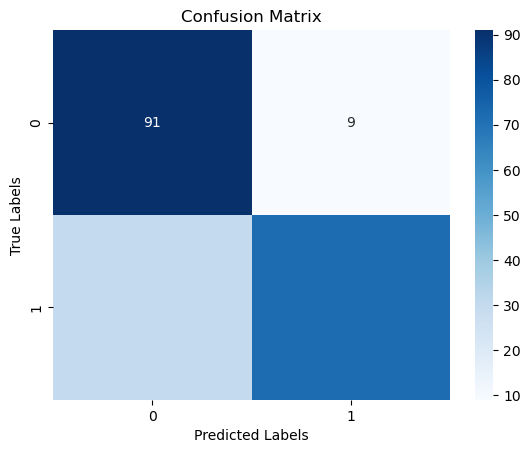

In [65]:
cf = confusion_matrix(_true_labels, _pred_base)
print(cf)
sns.heatmap(cf, annot = True, cmap = 'Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()